In [5]:
import sys
import os
from datetime import datetime
from pathlib import Path

# Import necessary libraries
import logging
import traceback
import numpy as np
import pandas as pd

# Scikit-learn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import (
    GridSearchCV, 
    KFold, 
    RepeatedKFold, 
    RepeatedStratifiedKFold,
    LeaveOneOut, 
    StratifiedKFold
)


from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    explained_variance_score
)

from sklearn.feature_selection import SelectKBest, f_classif


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
import xgboost as xgb


pd.set_option('display.max_columns', None)

sys.path.append(os.path.abspath("../src"))  

def bold_max(df, dataset="", precision=2):
    """
    Return a Styler that bolds the column-wise maxima.

    Works with both:
    - numeric values
    - strings in the format '0.84 ± 0.02'

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with either numeric or 'mean ± std' strings.
    dataset : str
        A caption or title to display above the table.
    precision : int, default 2
        Number of decimals to show if numeric.
    """
    def is_string_with_std(val):
        return isinstance(val, str) and '±' in val
    
    def is_string_with_bracket(val):
        return isinstance(val, str) and '[' in val

    if df.applymap(is_string_with_std).all().all():
        # All cells are strings with ±
        def highlight_max(col):
            means = col.str.extract(r"(\d+\.\d+) ±")[0].astype(float)
            max_val = means.max()
            return ['font-weight: bold' if v == max_val else '' for v in means]

        return df.style.set_caption(f"Dataset: {dataset}").apply(highlight_max, axis=0)

    else:
        # Assume numeric DataFrame
        return (
            df.style
              .set_caption(f"Dataset: {dataset}")
              .format(f"{{:.{precision}f}}")
              .apply(lambda col: ['font-weight: bold' if v == col.max() else '' for v in col], axis=0)
        )


In [ ]:
processed_path = '../data/processed/'
# Read data
df_digital_tmt_with_target = pd.read_csv(processed_path + 'df_digital_tmt_with_target.csv') 
demographic_df = pd.read_csv(processed_path + 'demographic_df.csv') 
non_digital_df = pd.read_csv(processed_path + 'non_digital_df.csv') 
df_digital_hand_and_eye = pd.read_csv(processed_path + 'df_digital_hand_and_eye.csv') 
digital_test_less_subjects = pd.read_csv(processed_path + 'digital_test_less_subjects.csv') 
non_digital_test_less_subjects = pd.read_csv(processed_path + 'non_digital_test_less_subjects.csv') 


# Final checks
print(df_digital_tmt_with_target['group'].value_counts())
print(demographic_df['group'].value_counts())
print(non_digital_df['group'].value_counts())
print(df_digital_hand_and_eye['group'].value_counts())
print(digital_test_less_subjects['group'].value_counts())
print(non_digital_test_less_subjects['group'].value_counts())

In [ ]:
# Configure logging
# Ensure logs folder exists
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
# Create a fresh log file each run
log_filename = os.path.join(log_dir, f"error_log_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log")
logging.basicConfig(filename=log_filename,
                    level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')


# ───────────────────────────────────────────────────────────────
# 0. SET-UP GENERAL 
# ───────────────────────────────────────────────────────────────
n_splits = 2
n_repeats = 1

global_seed = 42
inner_cv_seed = 50  # Fixed for reproducibility in inner CV
perform_pca = False
type_of_csv = 'loo'
n_components = 4
tune_hyperparameters = False
feature_selection = True

datasets = [
            # N=79
            'demographic', 
            'digital_test', 
            'demographic+digital',
            'non_digital_tests', 
            'non_digital_tests+demo',

            # N=56
            'demographic_less_subjects', 
            'digital_test_less_subjects', 
            'demographic+digital_less',
            'hand_and_eye',
            'hand_and_eye_demo',
            'non_digital_test_less_subjects', 
            'non_digital_test_less_subjects+demo'
            ]

datasets = ['non_digital_test_less_subjects+demo']


def extract_X_y_features_regression(df, metadata):
    if metadata.columns[-1] not in df.columns:
        df = df.merge(metadata, how='inner', on='suj')

    df = df.drop(['suj', 'group'], axis=1)
    print("group in X", 'group' in df.iloc[:, :-1].columns)
    print("suj in X", 'suj' in df.iloc[:, :-1].columns)
    display(df.head(2))
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    feature_names = df.columns[:-1]
    
    return X, y, feature_names 

def join_and_reorder_regression(df1, df2):
    df = df1.join(df2.drop(columns='group'))
    cols = [col for col in df.columns if col != 'group'] + ['group']
    df = df[cols]
    assert df.columns[-1] == 'group', "'group' is not the last column after reordering"
    return df

target_variable = 'mmse'
df_metadata_for_ml = pd.read_csv("metadata_for_ml.csv")

df_y = df_metadata_for_ml[['suj',target_variable]]

for value in [True, False]: 
    perform_pca = value
    for dataset in datasets:
        try:
            print(f"Starting {dataset}: \n\n")
            if perform_pca:
                print("Performing PCA")

            match dataset:
                case 'demographic':
                    X, y, feature_names = extract_X_y_features_regression(demographic_df, df_y)

                case 'demographic_less_subjects':  
                    df = demographic_df.loc[df_digital_hand_and_eye.index]
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case 'demographic+digital':
                    df = join_and_reorder_regression(df_digital_tmt_with_target, demographic_df)
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case 'demographic+digital_less':
                    df = join_and_reorder_regression(df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index], demographic_df)
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case 'non_digital_tests':
                    # non_digital_df = non_digital_df.drop(target_variable, axis=1)
                    X, y, feature_names = extract_X_y_features_regression(non_digital_df, df_y)

                case 'non_digital_tests+demo':
                    df = join_and_reorder_regression(non_digital_df.drop(columns=['suj', target_variable]), demographic_df)
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case 'non_digital_test_less_subjects':
                    X, y, feature_names = extract_X_y_features_regression(non_digital_test_less_subjects, df_y)

                case 'non_digital_test_less_subjects+demo':
                    # non_digital_test_less_subjects = non_digital_test_less_subjects.drop(target_variable, axis=1)
                    df = join_and_reorder_regression(non_digital_test_less_subjects.drop(columns='suj'), demographic_df)
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case 'digital_test':
                    X, y, feature_names = extract_X_y_features_regression(df_digital_tmt_with_target, df_y)

                case 'digital_test_less_subjects':
                    X, y, feature_names = extract_X_y_features_regression(digital_test_less_subjects, df_y)

                case 'hand_and_eye':
                    X, y, feature_names = extract_X_y_features_regression(df_digital_hand_and_eye, df_y)

                case 'hand_and_eye_demo':
                    df = join_and_reorder_regression(df_digital_hand_and_eye, demographic_df)
                    X, y, feature_names = extract_X_y_features_regression(df, df_y)

                case _:
                    raise ValueError(f'Please select a valid dataset from: {datasets}')


                # ───────────────────────────────────────────────────────────────
            # 1. DEFINICIÓN DE PARÁMETROS Y MODELOS 
            # ───────────────────────────────────────────────────────────────

            # Display target variable statistics
            print(f"Target variable statistics for {target_variable}:")
            print(f"  Mean: {np.mean(y):.3f}")
            print(f"  Std: {np.std(y):.3f}")
            print(f"  Min: {np.min(y):.3f}")
            print(f"  Max: {np.max(y):.3f}")
            print(f"  Valid samples: {len(y)}")

            # Define parameter grids for regression models
            param_grids = {
                "RandomForestRegressor": {
                    "regressor__n_estimators": [100, 500, 700, 1000],
                    "regressor__max_depth": [None, 10, 20, 30]
                },
                "SVR": {
                    "regressor__C": [0.1, 1, 10],
                    "regressor__kernel": ['linear', 'rbf'],
                    "regressor__epsilon": [0.01, 0.1, 0.2]
                },
                "LinearRegression": {
                    # LinearRegression has no hyperparameters to tune
                },
                "Ridge": {
                    "regressor__alpha": [0.1, 1.0, 10.0, 100.0]
                },
                "Lasso": {
                    "regressor__alpha": [0.01, 0.1, 1.0, 10.0]
                },
                "XGBRegressor": {
                    "regressor__n_estimators": [100, 300],
                    "regressor__max_depth": [3, 5],
                    "regressor__learning_rate": [0.05, 0.1]
                }
            }

            # Define regression models to evaluate
            models = [
                RandomForestRegressor(random_state=42, n_jobs=-1),
                SVR(),
                LinearRegression(n_jobs=-1),
                Ridge(random_state=42),
                Lasso(random_state=42),
                xgb.XGBRegressor(random_state=42, tree_method="hist", n_jobs=-1)
            ]

            # ───────────────────────────────────────────────────────────────
            # 2. Cross validation
            # ───────────────────────────────────────────────────────────────

            match type_of_csv:
                case 'kfold':
                    print(f"RepeatedKFold selected with n_splits = {n_splits} and n_repeats = {n_repeats}")
                    outer_cv = RepeatedKFold(
                        n_splits=n_splits,
                        n_repeats=n_repeats,         
                        random_state=global_seed # Global seed
                    )
                case 'loo':
                    print("LeaveOneOut selected")
                    outer_cv = LeaveOneOut()
                case _:
                    print("select a valid CV type (kfold or loo)")

            all_metrics_df = pd.DataFrame(columns=[
                'dataset', 'target_column', 'model', 'repeat', 'fold',   
                'mse', 'rmse', 'mae', 'r2', 'explained_variance'
            ])

            # ───────────────────────────────────────────────────────────────
            # 3. External loop 
            # ───────────────────────────────────────────────────────────────
            for model in models:
                model_name = model.__class__.__name__
                print(f"\n🧪 CV for: {model_name}")

                best_params_list, fold_metrics = [], []
                feature_importance_counts = {n: 0 for n in feature_names}

                all_y_true, all_y_pred = [], []

                # Enumeramos 'repeat' y 'fold' para guardar en métricas
                for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
                    n_features = min(20, X.shape[1])  # Ensure we don't exceed available features
                    n_components_actual = min(n_components, X.shape[1])
                    fold = outer_idx  # index of the left-out observation
                    print(f'fold: {fold}')

                    # ── Split
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]

                    
                    # ── Inner CV: regular KFold for regression (no stratification needed)
                    inner_cv = KFold(n_splits=min(3, len(y_train)), shuffle=True, random_state=inner_cv_seed)
                    
                    if perform_pca:
                        print("n_components:", n_components_actual)
                        pca_step = ('pca', PCA(n_components=n_components_actual))
                    else:
                        pca_step = ('noop', 'passthrough')

                    
                    if feature_selection:
                        print("n_features:", n_features)
                        # Use f_regression for regression feature selection
                        feature_selection_step = ('select', SelectKBest(score_func=f_regression, k=n_features))
                    else:
                        feature_selection_step = ('noop', 'passthrough')

                    pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy='mean')),  # or 'median' depending on your data
                        feature_selection_step,
                        ('scaler', StandardScaler()),
                        pca_step,
                        ('regressor', model)  # Changed from 'classifier' to 'regressor'
                    ])

                    # Hiperparámetros
                    param_grid = param_grids.get(model_name, {})

                    if tune_hyperparameters and param_grid:
                        grid = GridSearchCV(
                            pipeline,
                            param_grid=param_grid,
                            cv=inner_cv,               
                            scoring='neg_mean_squared_error',  # Changed from 'roc_auc' to regression metric
                            n_jobs=-1,
                            verbose=0
                        )
                        grid.fit(X_train, y_train)
                        best_model = grid.best_estimator_
                        best_params_list.append(grid.best_params_)
                    else:
                        pipeline.fit(X_train, y_train)
                        best_model = pipeline
                        best_params_list.append("no tuning")

                    # ── Prediction (no probability prediction for regression)
                    y_pred = best_model.predict(X_test)

                    all_y_true.extend(y_test)
                    all_y_pred.extend(y_pred)

                    fold_metrics.append({
                        'dataset': dataset,
                        'target_column': target_variable,
                        'model': model_name,
                        'fold': fold,              
                        'y_test': y_test[0] if len(y_test) == 1 else y_test,
                        'y_pred': y_pred[0] if len(y_pred) == 1 else y_pred,
                        'feature_names': feature_names.values
                    })

                # ── Guardamos métricas
                all_metrics_df = pd.concat([all_metrics_df,
                                            pd.DataFrame(fold_metrics)],
                                        ignore_index=True)



        # save
            dir = f'./results/modelling/regression/{datetime.now().strftime("%Y-%m-%d")}'
            os.makedirs(dir, exist_ok=True)
            if perform_pca:
                all_metrics_df.to_csv(f'{dir}/{dataset}_feature_{feature_selection}_n={n_features}_tune={tune_hyperparameters}_LOOCV_PCA_n_components{n_components}_{datetime.now().strftime("%s")[-4:]}.csv',index=False)
            else:
                all_metrics_df.to_csv(f'{dir}/{dataset}_feature_{feature_selection}_n={n_features}_tune={tune_hyperparameters}_LOOCV_{datetime.now().strftime("%s")[-4:]}.csv',index=False)
        except Exception as e:
            print(e)
            error_msg = traceback.format_exc().strip().split("\n")[-1]  # only last line of error
            logging.error(f"[{dataset}] PCA={perform_pca} → {error_msg}")
            print(f"⚠️ An error occurred with dataset {dataset}. Check log file: {log_filename}")



In [ ]:
from pathlib import Path
import pandas as pd
import re

# Ruta a los archivos guardados
results_dir = Path('./results/modelling/regression/2025-07-08')

# Buscar todos los .csv
file_paths = [f for f in results_dir.rglob('*.csv') if f.is_file()]

all_results = []

for path in file_paths:
    print(f"Loading {path.name}")
    df = pd.read_csv(path)

    # Extraer el nombre del dataset desde el nombre del archivo
    match = re.search(r"(.*?)_feature", path.stem)
    dataset_name = match.group(1) if match else path.stem

    df["dataset"] = dataset_name
    df["PCA"] = 'PCA' in str(path)
    df["features"] = 'feature' in str(path)
    df["complete"] = not (('less' in str(path)) or ('eye' in str(path)))

    all_results.append(df)

all_datasets_df = pd.concat(all_results, ignore_index=True)


In [11]:
all_datasets_df

,dataset,target_column,model,repeat,fold,mse,rmse,mae,r2,explained_variance,y_test,y_pred,feature_names,PCA,features,complete,accuracy,balanced_accuracy,precision,recall,f1,auc,specificity,y_pred_proba
0,non_digital_test_less_subjects+demo,mmse,RandomForestRegressor,NaN,0,NaN,NaN,NaN,NaN,NaN,28.0,28.080000,['tmt_a_raw' 'tmt_a_z' 'tmt_b_raw' 'tmt_b_z' '...,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,non_digital_test_less_subjects+demo,mmse,RandomForestRegressor,NaN,1,NaN,NaN,NaN,NaN,NaN,28.0,29.370000,['tmt_a_raw' 'tmt_a_z' 'tmt_b_raw' 'tmt_b_z' '...,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,non_digital_test_less_subjects+demo,mmse,RandomForestRegressor,NaN,2,NaN,NaN,NaN,NaN,NaN,25.0,25.640000,['tmt_a_raw' 'tmt_a_z' 'tmt_b_raw' 'tmt_b_z' '...,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,non_digital_test_less_subjects+demo,mmse,RandomForestRegressor,NaN,3,NaN,NaN,NaN,NaN,NaN,29.0,28.740000,['tmt_a_raw' 'tmt_a_z' 'tmt_b_raw' 'tmt_b_z' '...,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,non_digital_test_less_subjects+demo,mmse,RandomForestRegressor,NaN,4,NaN,NaN,NaN,NaN,NaN,26.0,28.580000,['tmt_a_raw' 'tmt_a_z' 'tmt_b_raw' 'tmt_b_z' '...,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,non_digital_test_less_subjects+demo,mmse,XGBRegressor,NaN,47,27.000231,5.196175,5.196175,NaN,1.0,30.0,24.803825,['tmt_a_raw' 'tmt_a_z' 'tmt_b_raw' 'tmt_b_z' '...,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1296,non_digital_test_less_subjects+demo,mmse,XGBRegressor,NaN,48,2.453569,1.566387,1.566387,NaN,1.0,28.0,29.566387,['tmt_a_raw' 'tmt_a_z' 'tmt_b_raw' 'tmt_b_z' '...,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1297,non_digital_test_less_subjects+demo,mmse,XGBRegressor,NaN,49,2.398975,1.548862,1.548862,NaN,1.0,26.0,27.548862,['tmt_a_raw' 'tmt_a_z' 'tmt_b_raw' 'tmt_b_z' '...,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1298,non_digital_test_less_subjects+demo,mmse,XGBRegressor,NaN,50,20.545677,4.532734,4.532734,NaN,1.0,25.0,29.532734,['tmt_a_raw' 'tmt_a_z' 'tmt_b_raw' 'tmt_b_z' '...,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

metrics_global = []

for (dataset, model), group in all_datasets_df.groupby(['dataset', 'model']):
    y_true = group['y_test'].tolist()
    y_pred = group['y_pred'].tolist()

    metrics_global.append({
        'dataset': dataset,
        'model': model,
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'explained_variance': explained_variance_score(y_true, y_pred),
        'PCA': group['PCA'].iloc[0],
        'features': group['features'].iloc[0],
        'complete': group['complete'].iloc[0],
    })

global_df = pd.DataFrame(metrics_global)


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Agrupar por modelo y dataset
global_metrics = []

for (dataset, model), group in all_datasets_df.groupby(['dataset', 'model']):
    y_true = group['y_test'].values
    y_pred = group['y_pred'].values

    global_metrics.append({
        'dataset': dataset,
        'model': model,
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'explained_variance': explained_variance_score(y_true, y_pred)
    })

global_df = pd.DataFrame(global_metrics)


In [17]:
global_df

,dataset,model,mse,rmse,mae,r2,explained_variance
0,non_digital_test_less_subjects+demo,Lasso,4.257739,2.063429,1.668296,-0.016773,-0.016773
1,non_digital_test_less_subjects+demo,LinearRegression,4.381281,2.093151,1.710015,-0.046276,-0.045688
2,non_digital_test_less_subjects+demo,LogisticRegression,6.307692,2.511512,1.961538,-0.506315,-0.437075
3,non_digital_test_less_subjects+demo,RandomForestRegressor,4.442365,2.107692,1.699423,-0.060863,-0.060599
4,non_digital_test_less_subjects+demo,Ridge,4.284005,2.069784,1.689560,-0.023046,-0.022655
5,non_digital_test_less_subjects+demo,SVR,4.204635,2.050521,1.619018,-0.004092,0.022235
6,non_digital_test_less_subjects+demo,XGBRegressor,6.072666,2.464278,2.006466,-0.450189,-0.449847


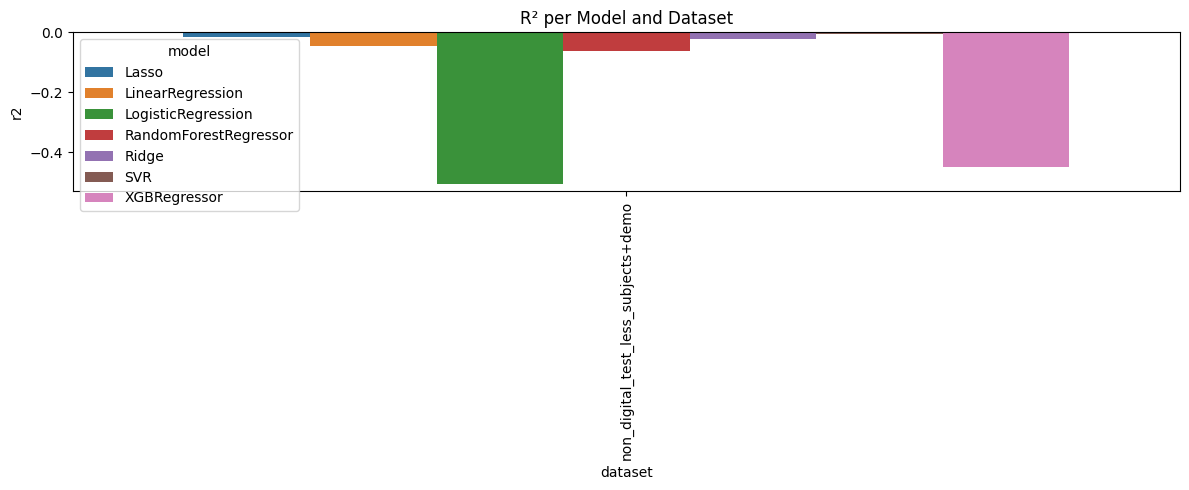

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.barplot(data=global_df, x='dataset', y='r2', hue='model')
plt.xticks(rotation=90)
plt.title("R² per Model and Dataset")
plt.tight_layout()
plt.show()


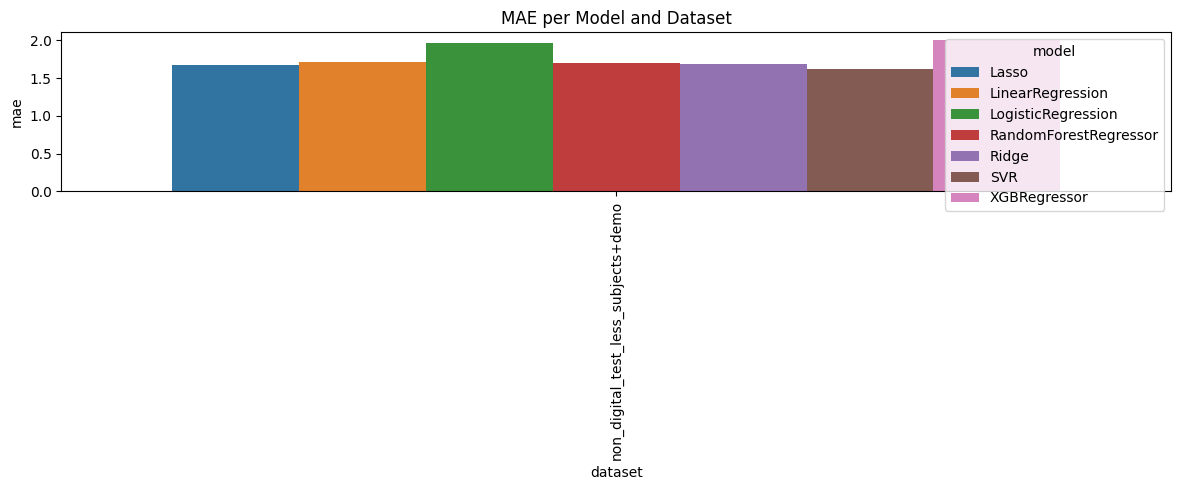

In [14]:
plt.figure(figsize=(12, 5))
sns.barplot(data=global_df, x='dataset', y='mae', hue='model')
plt.xticks(rotation=90)
plt.title("MAE per Model and Dataset")
plt.tight_layout()
plt.show()


In [15]:
top_models = global_df.sort_values("mse").groupby("dataset", as_index=False).first()
display(top_models[['dataset', 'model', 'mse', 'r2']])


,dataset,model,mse,r2
0,non_digital_test_less_subjects+demo,SVR,4.204635,-0.004092
